## Modulos necesarios

In [1]:
import numpy as np
  
from keras.models import Model
from keras.layers import *
from keras.optimizers import *
import keras.backend as K
from keras.callbacks import EarlyStopping
import keras.utils as image

import tensorflow as tf

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix 
from sklearn.model_selection import KFold

import os
from os import listdir

import natsort # it may need to be installed by 'pip install natsort'

import datetime
now = datetime.datetime.now

2023-12-06 11:43:43.194327: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-06 11:43:43.226953: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-06 11:43:43.226982: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-06 11:43:43.228097: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-06 11:43:43.233447: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-06 11:43:43.234039: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [2]:
import numpy as np
from glob import glob

from tensorflow import keras
from tensorflow.keras.backend import max
from tensorflow.keras.metrics import BinaryAccuracy
import keras_unet_collection
from keras_unet_collection import models, base, utils

In [3]:
import keras.backend as K

# Extracción de imágenes

In [4]:
# Introduce parameters
img_row = 128
img_col = 128
img_chan = 1
epochnum = 200
batchnum = 16 
num_imgs = 780
input_size = (img_row, img_col, img_chan)

In [5]:
path = r'images/'

images = []
masks = []


for f_name in os.listdir(path):
    file_name = os.path.join(path,f_name)
    for name in os.listdir(file_name):
        file = os.path.join(file_name,name)
            
        if 'lesion' in file:
            tmp_mask = image.load_img(os.path.join(file_name, name, name + ".bmp"), target_size=(img_row, img_col, img_chan))
            mask = image.img_to_array(tmp_mask)
            masks.append(mask[:,:,0]/255.0) 

        elif "Dermoscopic" in file:
            tmp_img = image.load_img(os.path.join(file_name, name, f_name + ".bmp"), target_size=(img_row, img_col, img_chan))
            img = image.img_to_array(tmp_img)
            images.append(img[:,:,0]/255.0) 


In [6]:
num_imgs = len(images)
print(num_imgs)
num_masks = len(masks)
print(num_masks)
imgs = np.zeros((num_imgs, img_row, img_col))
masks_ = np.zeros_like(imgs)

for i in range(num_imgs):
    imgs[i] = images[i]
    
for i in range(num_imgs):
    masks_[i] = masks[i]

200
200


# Métricas de evaluación y entrenamiento (DICE)

In [7]:
# Define loss and performance metrics
# Partially from Abraham and Khan (2019) - A Novel Focal Tversly Loss Function for Lesion Segmentation

# Dice score coefficient and Dice loss 
def dsc(y_true, y_pred):
    smooth = 1.
    # masks
    y_true_fm = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_fm * y_pred_f)
    score = (2. * intersection + smooth) / (K.sum(y_true_fm) + K.sum(y_pred_f) + smooth) 
    return score

def dice_loss(y_true, y_pred):
    loss = 1 - dsc(y_true, y_pred)
    return loss

# Performance metrics: Dice score coefficient, IOU, recall, sensitivity
def auc(y_true, y_pred):
    y_pred_pos = np.round(np.clip(y_pred, 0, 1))
    y_pred_neg = 1 - y_pred_pos
    y_pos = np.round(np.clip(y_true, 0, 1)) # ground truth
    y_neg = 1 - y_pos
    tp = np.sum(y_pos * y_pred_pos)
    tn = np.sum(y_neg * y_pred_neg)
    fp = np.sum(y_neg * y_pred_pos)
    fn = np.sum(y_pos * y_pred_neg)
    tpr = (tp + K.epsilon()) / (tp + fn + K.epsilon()) #recall
    tnr = (tn + K.epsilon()) / (tn + fp + K.epsilon())
    prec = (tp + K.epsilon()) / (tp + fp + K.epsilon()) #precision
    iou = (tp + K.epsilon()) / (tp + fn + fp + K.epsilon()) #intersection over union
    dsc = (2*tp + K.epsilon()) / (2*tp + fn + fp + K.epsilon()) #dice score
    return [dsc, iou, tpr, prec]

## Separación train y test

In [8]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(imgs, masks_, test_size=0.3, random_state = 0)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.2, random_state = 0)

## Representación de train y validación

In [9]:
def Representacion(history,epochnum, batchnum):
    print('Training time: %s' % (now() - t))

    #Plot the loss and accuracy
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    acc = history.history['dsc'] 
    val_acc = history.history['val_dsc']

    epochsn = np.arange(1, len(train_loss)+1,1)
    plt.figure(figsize = (12,5))
    plt.subplot(121)
    plt.plot(epochsn,train_loss, 'b', label='Training Loss')
    plt.plot(epochsn,val_loss, 'r', label='Validation Loss')
    plt.grid(color='gray', linestyle='--')
    plt.legend()
    plt.title('LOSS, Epochs={}, Batch={}'.format(epochnum, batchnum))
    plt.xlabel('Epochs')
    plt.ylabel('Loss')

    plt.subplot(122)
    plt.plot(epochsn, acc, 'b', label='Training Dice Coefficient')
    plt.plot(epochsn, val_acc, 'r', label='Validation Dice Coefficient')
    plt.grid(color='gray', linestyle='--')
    plt.legend()            
    plt.title('DSC, Epochs={}, Batch={}'.format(epochnum, batchnum))
    plt.xlabel('Epochs')
    plt.ylabel('CSC')
    
    plt.savefig('Graph_UNET.png')
    plt.show()

# U-NET

In [10]:
# Convolutional block for UNet
def ConvBlock(in_fmaps, num_fmaps):
    # Inputs: feature maps for UNet, number of output feature maps
    conv1 = Conv2D(num_fmaps, (3, 3), activation='relu', padding='same')(in_fmaps)
    conv_out = Conv2D(num_fmaps, (3, 3), activation='relu', padding='same')(conv1)
    return conv_out

In [11]:
# Build the model
def Network():
    
    input = Input(shape=input_size)

    conv1 = ConvBlock(input, 32)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = ConvBlock(pool1, 32)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = ConvBlock(pool2, 64)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = ConvBlock(pool3, 64)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = ConvBlock(pool4, 128)

    up6 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = ConvBlock(up6, 64)

    up7 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = ConvBlock(up7, 64)

    up8 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = ConvBlock(up8, 32)

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = ConvBlock(up9, 32)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    model = Model(inputs = input, outputs = conv10)

    return model

In [12]:
model = Network()
model.compile(optimizer = Adam(learning_rate = 0.0001), loss = dice_loss, metrics = [dsc])

In [13]:
t = now()

history = model.fit(X_train, Y_train, validation_data = (X_val, Y_val), batch_size=batchnum, epochs=epochnum, verbose=1)

Epoch 1/200
7/7 [==============================] - 9s 914ms/step - loss: 0.6115 - dsc: 0.3885 - val_loss: 0.5887 - val_dsc: 0.4127
Epoch 2/200
7/7 [==============================] - 6s 856ms/step - loss: 0.6059 - dsc: 0.3941 - val_loss: 0.5841 - val_dsc: 0.4173
Epoch 3/200
7/7 [==============================] - 7s 946ms/step - loss: 0.5983 - dsc: 0.4017 - val_loss: 0.5786 - val_dsc: 0.4228
Epoch 4/200
7/7 [==============================] - 6s 843ms/step - loss: 0.5912 - dsc: 0.4088 - val_loss: 0.5697 - val_dsc: 0.4318
Epoch 5/200
7/7 [==============================] - 6s 880ms/step - loss: 0.5795 - dsc: 0.4205 - val_loss: 0.5508 - val_dsc: 0.4507
Epoch 6/200
7/7 [==============================] - 6s 817ms/step - loss: 0.5512 - dsc: 0.4488 - val_loss: 0.5088 - val_dsc: 0.4930
Epoch 7/200
7/7 [==============================] - 6s 824ms/step - loss: 0.5195 - dsc: 0.4805 - val_loss: 0.4854 - val_dsc: 0.5167
Epoch 8/200
7/7 [==============================] - 6s 890ms/step - loss: 0.5174 - d

7/7 [==============================] - 7s 960ms/step - loss: 0.1219 - dsc: 0.8781 - val_loss: 0.0887 - val_dsc: 0.9111
Epoch 64/200
7/7 [==============================] - 7s 966ms/step - loss: 0.1196 - dsc: 0.8804 - val_loss: 0.0882 - val_dsc: 0.9124
Epoch 65/200
7/7 [==============================] - 7s 1s/step - loss: 0.1231 - dsc: 0.8769 - val_loss: 0.0941 - val_dsc: 0.9051
Epoch 66/200
7/7 [==============================] - 7s 973ms/step - loss: 0.1234 - dsc: 0.8766 - val_loss: 0.0888 - val_dsc: 0.9103
Epoch 67/200
7/7 [==============================] - 6s 937ms/step - loss: 0.1210 - dsc: 0.8790 - val_loss: 0.1069 - val_dsc: 0.8931
Epoch 68/200
7/7 [==============================] - 6s 919ms/step - loss: 0.1379 - dsc: 0.8621 - val_loss: 0.1129 - val_dsc: 0.8866
Epoch 69/200
7/7 [==============================] - 6s 842ms/step - loss: 0.1285 - dsc: 0.8715 - val_loss: 0.0957 - val_dsc: 0.9029
Epoch 70/200
7/7 [==============================] - 6s 933ms/step - loss: 0.1204 - dsc: 0.87

7/7 [==============================] - 6s 900ms/step - loss: 0.0801 - dsc: 0.9199 - val_loss: 0.0809 - val_dsc: 0.9178
Epoch 126/200
7/7 [==============================] - 6s 915ms/step - loss: 0.0805 - dsc: 0.9195 - val_loss: 0.0838 - val_dsc: 0.9152
Epoch 127/200
7/7 [==============================] - 6s 923ms/step - loss: 0.0861 - dsc: 0.9139 - val_loss: 0.0802 - val_dsc: 0.9182
Epoch 128/200
7/7 [==============================] - 7s 962ms/step - loss: 0.0843 - dsc: 0.9157 - val_loss: 0.0783 - val_dsc: 0.9211
Epoch 129/200
7/7 [==============================] - 6s 941ms/step - loss: 0.0814 - dsc: 0.9186 - val_loss: 0.0909 - val_dsc: 0.9073
Epoch 130/200
7/7 [==============================] - 7s 966ms/step - loss: 0.0830 - dsc: 0.9170 - val_loss: 0.0878 - val_dsc: 0.9106
Epoch 131/200
7/7 [==============================] - 6s 894ms/step - loss: 0.0826 - dsc: 0.9174 - val_loss: 0.0887 - val_dsc: 0.9104
Epoch 132/200
7/7 [==============================] - 6s 929ms/step - loss: 0.0938 -

Epoch 187/200
7/7 [==============================] - 6s 874ms/step - loss: 0.0650 - dsc: 0.9350 - val_loss: 0.0857 - val_dsc: 0.9138
Epoch 188/200
7/7 [==============================] - 6s 869ms/step - loss: 0.0616 - dsc: 0.9384 - val_loss: 0.0845 - val_dsc: 0.9151
Epoch 189/200
7/7 [==============================] - 6s 822ms/step - loss: 0.0598 - dsc: 0.9402 - val_loss: 0.0865 - val_dsc: 0.9128
Epoch 190/200
7/7 [==============================] - 6s 889ms/step - loss: 0.0598 - dsc: 0.9402 - val_loss: 0.0851 - val_dsc: 0.9147
Epoch 191/200
7/7 [==============================] - 6s 828ms/step - loss: 0.0588 - dsc: 0.9412 - val_loss: 0.0857 - val_dsc: 0.9133
Epoch 192/200
7/7 [==============================] - 6s 862ms/step - loss: 0.0592 - dsc: 0.9408 - val_loss: 0.0870 - val_dsc: 0.9132
Epoch 193/200
7/7 [==============================] - 6s 903ms/step - loss: 0.0582 - dsc: 0.9418 - val_loss: 0.0806 - val_dsc: 0.9186
Epoch 194/200
7/7 [==============================] - 6s 937ms/step - 

In [14]:
# Make predictions
t = now()
preds_UNET = model.predict(X_test)
print('Testing time: %s' % (now() - t))
print(len(X_train[112:140]))

2/2 [==============================] - 1s 220ms/step
Testing time: 0:00:00.695921
0


Training time: 0:00:00.699055


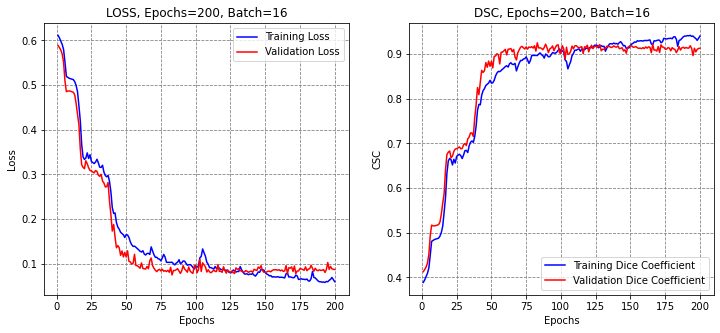

In [15]:
Representacion(history,epochnum, batchnum)

In [16]:
train_loss = history.history['loss']
epochsn = np.arange(1, len(train_loss)+1,1)
# Evaluate model
num_test = len(X_test)

# Calculate performance metrics
dsc_sc = np.zeros((num_test,1))
iou_sc = np.zeros_like(dsc_sc)
rec_sc = np.zeros_like(dsc_sc)
tn_sc = np.zeros_like(dsc_sc)
prec_sc = np.zeros_like(dsc_sc)
thresh = 0.5
for i in range(num_test):
    dsc_sc[i], iou_sc[i], rec_sc[i], prec_sc[i] = auc(Y_test[i], preds_UNET[i,:,:,0] >thresh)
print('-'*30)
print('USING THRESHOLD', thresh)
print('\n DSC \t\t{0:^.3f} \n IOU \t\t{1:^.3f} \n Recall \t{2:^.3f} \n Precision\t{3:^.3f}'.format(
        np.sum(dsc_sc)/num_test,  
        np.sum(iou_sc)/num_test,  
        np.sum(rec_sc)/num_test,
        np.sum(prec_sc)/num_test))
    
# Confusion matrix
confusion = confusion_matrix(Y_test.ravel(),preds_UNET.ravel()>thresh)
accuracy = 0
if float(np.sum(confusion))!=0:
    accuracy = float(confusion[0,0]+confusion[1,1])/float(np.sum(confusion))
print(' Global Acc \t{0:^.3f}'.format(accuracy))
    
# Area under the ROC curve
AUC_ROC = roc_auc_score(preds_UNET.ravel()>thresh, Y_test.ravel())
print(' AUC ROC \t{0:^.3f}'.format(AUC_ROC))
print('\n')
print('*'*60)
    
# Save outputs 
numepochs = epochsn[-1]
dice_score = np.sum(dsc_sc)/num_test
iou_score = np.sum(iou_sc)/num_test
rec_score = np.sum(rec_sc)/num_test
prec_score = np.sum(prec_sc)/num_test
globacc_score = accuracy
auc_roc_score = AUC_ROC

------------------------------
USING THRESHOLD 0.5

 DSC 		0.864 
 IOU 		0.775 
 Recall 	0.884 
 Precision	0.871
 Global Acc 	0.927
 AUC ROC 	0.912


************************************************************


In [17]:
preds_UNET_val = model.predict(X_val)
val_loss = history.history['val_loss']
epochsn = np.arange(1, len(val_loss)+1,1)
# Evaluate model
num_val = len(X_val)

# Calculate performance metrics
dsc_sc = np.zeros((num_val,1))
iou_sc = np.zeros_like(dsc_sc)
rec_sc = np.zeros_like(dsc_sc)
tn_sc = np.zeros_like(dsc_sc)
prec_sc = np.zeros_like(dsc_sc)
thresh = 0.5
for i in range(num_val):
    dsc_sc[i], iou_sc[i], rec_sc[i], prec_sc[i] = auc(Y_test[i], preds_UNET_val[i,:,:,0] >thresh)
print('-'*30)
print('USING THRESHOLD', thresh)
print('\n DSC \t\t{0:^.3f} \n IOU \t\t{1:^.3f} \n Recall \t{2:^.3f} \n Precision\t{3:^.3f}'.format(
        np.sum(dsc_sc)/num_val,  
        np.sum(iou_sc)/num_val,  
        np.sum(rec_sc)/num_val,
        np.sum(prec_sc)/num_val))
    
# Confusion matrix
confusion = confusion_matrix(Y_val.ravel(),preds_UNET_val.ravel()>thresh)
accuracy = 0
if float(np.sum(confusion))!=0:
    accuracy = float(confusion[0,0]+confusion[1,1])/float(np.sum(confusion))
print(' Global Acc \t{0:^.3f}'.format(accuracy))
    
# Area under the ROC curve
AUC_ROC = roc_auc_score(preds_UNET_val.ravel()>thresh, Y_val.ravel())
print(' AUC ROC \t{0:^.3f}'.format(AUC_ROC))
print('\n')
print('*'*60)
    
# Save outputs 
numepochs = epochsn[-1]
dice_score = np.sum(dsc_sc)/num_val
iou_score = np.sum(iou_sc)/num_val
rec_score = np.sum(rec_sc)/num_val
prec_score = np.sum(prec_sc)/num_val
globacc_score = accuracy
auc_roc_score = AUC_ROC


1/1 [==============================] - 0s 275ms/step
------------------------------
USING THRESHOLD 0.5

 DSC 		0.461 
 IOU 		0.325 
 Recall 	0.616 
 Precision	0.628
 Global Acc 	0.940
 AUC ROC 	0.934


************************************************************


# U-NET Dense

In [18]:
from keras.layers import *

def DenseBlock(channels,inputs):

    conv1_1 = Conv2D(channels, (1, 1),activation=None, padding='same')(inputs)
    conv1_1=BatchActivate(conv1_1)
    conv1_2 = Conv2D(channels//4, (3, 3), activation=None, padding='same')(conv1_1)
    conv1_2 = BatchActivate(conv1_2)

    conv2=concatenate([inputs,conv1_2])
    conv2_1 = Conv2D(channels, (1, 1), activation=None, padding='same')(conv2)
    conv2_1 = BatchActivate(conv2_1)
    conv2_2 = Conv2D(channels // 4, (3, 3), activation=None, padding='same')(conv2_1)
    conv2_2 = BatchActivate(conv2_2)

    conv3 = concatenate([inputs, conv1_2,conv2_2])
    conv3_1 = Conv2D(channels, (1, 1), activation=None, padding='same')(conv3)
    conv3_1 = BatchActivate(conv3_1)
    conv3_2 = Conv2D(channels // 4, (3, 3), activation=None, padding='same')(conv3_1)
    conv3_2 = BatchActivate(conv3_2)

    conv4 = concatenate([inputs, conv1_2, conv2_2,conv3_2])
    conv4_1 = Conv2D(channels, (1, 1), activation=None, padding='same')(conv4)
    conv4_1 = BatchActivate(conv4_1)
    conv4_2 = Conv2D(channels // 4, (3, 3), activation=None, padding='same')(conv4_1)
    conv4_2 = BatchActivate(conv4_2)
    result=concatenate([inputs,conv1_2, conv2_2,conv3_2,conv4_2])
    return result

def BatchActivate(x):
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x

In [19]:
from keras.optimizers import *
from keras.models import *

def DenseUNet(start_neurons=16, keep_prob=0.9,block_size=7,lr=1e-3):

    inputs = Input(shape=input_size)
    conv1 = Conv2D(start_neurons * 1, (3, 3), activation=None, padding="same")(inputs)
    conv1 = BatchActivate(conv1)
    conv1 = DenseBlock(start_neurons * 1, conv1)
    pool1 = MaxPooling2D((2, 2))(conv1)

    conv2 = DenseBlock(start_neurons * 2, pool1)
    pool2 = MaxPooling2D((2, 2))(conv2)

    conv3 = DenseBlock(start_neurons * 4, pool2)
    pool3 = MaxPooling2D((2, 2))(conv3)


    convm = DenseBlock(start_neurons * 8, pool3)


    deconv3 = Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="same")(convm)
    uconv3 = concatenate([deconv3, conv3])
    uconv3 = Conv2D(start_neurons * 4, (1, 1), activation=None, padding="same")(uconv3)
    uconv3 = BatchActivate(uconv3)
    uconv3 = DenseBlock(start_neurons * 4, uconv3)


    deconv2 = Conv2DTranspose(start_neurons * 2, (3, 3), strides=(2, 2), padding="same")(uconv3)
    uconv2 = concatenate([deconv2, conv2])
    uconv2 = Conv2D(start_neurons * 2, (1, 1), activation=None, padding="same")(uconv2)
    uconv2 = BatchActivate(uconv2)
    uconv2 = DenseBlock(start_neurons * 2, uconv2)

    deconv1 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="same")(uconv2)
    uconv1 = concatenate([deconv1, conv1])
    uconv1 = Conv2D(start_neurons * 1, (1, 1), activation=None, padding="same")(uconv1)
    uconv1 = BatchActivate(uconv1)
    uconv1 = DenseBlock(start_neurons * 1, uconv1)

    output_layer_noActi = Conv2D(1, (1, 1), padding="same", activation=None)(uconv1)
    output_layer = Activation('sigmoid')(output_layer_noActi)
    
    model = Model(inputs=inputs, outputs=output_layer)
    model.compile(optimizer=Adam(lr=1e-3), loss=dice_loss, metrics=[dsc])

    return model

In [20]:
model = DenseUNet()
t = now()

history = model.fit(X_train, Y_train, validation_data = (X_val, Y_val), batch_size=batchnum, epochs=epochnum, verbose=1)

Epoch 1/200
7/7 [==============================] - 26s 2s/step - loss: 0.5584 - dsc: 0.4416 - val_loss: 0.5960 - val_dsc: 0.4053
Epoch 2/200
7/7 [==============================] - 11s 2s/step - loss: 0.4427 - dsc: 0.5573 - val_loss: 0.6026 - val_dsc: 0.3988
Epoch 3/200
7/7 [==============================] - 11s 2s/step - loss: 0.3468 - dsc: 0.6532 - val_loss: 0.6168 - val_dsc: 0.3844
Epoch 4/200
7/7 [==============================] - 12s 2s/step - loss: 0.3008 - dsc: 0.6992 - val_loss: 0.6435 - val_dsc: 0.3575
Epoch 5/200
7/7 [==============================] - 13s 2s/step - loss: 0.2758 - dsc: 0.7242 - val_loss: 0.6905 - val_dsc: 0.3103
Epoch 6/200
7/7 [==============================] - 12s 2s/step - loss: 0.2463 - dsc: 0.7537 - val_loss: 0.7137 - val_dsc: 0.2867
Epoch 7/200
7/7 [==============================] - 12s 2s/step - loss: 0.2228 - dsc: 0.7772 - val_loss: 0.7446 - val_dsc: 0.2557
Epoch 8/200
7/7 [==============================] - 12s 2s/step - loss: 0.2252 - dsc: 0.7748 - val

7/7 [==============================] - 12s 2s/step - loss: 0.0741 - dsc: 0.9259 - val_loss: 0.1721 - val_dsc: 0.8304
Epoch 65/200
7/7 [==============================] - 12s 2s/step - loss: 0.0659 - dsc: 0.9341 - val_loss: 0.1733 - val_dsc: 0.8276
Epoch 66/200
7/7 [==============================] - 12s 2s/step - loss: 0.0528 - dsc: 0.9472 - val_loss: 0.1806 - val_dsc: 0.8194
Epoch 67/200
7/7 [==============================] - 11s 2s/step - loss: 0.0481 - dsc: 0.9519 - val_loss: 0.1519 - val_dsc: 0.8494
Epoch 68/200
7/7 [==============================] - 11s 2s/step - loss: 0.0414 - dsc: 0.9586 - val_loss: 0.1299 - val_dsc: 0.8709
Epoch 69/200
7/7 [==============================] - 12s 2s/step - loss: 0.0377 - dsc: 0.9623 - val_loss: 0.1105 - val_dsc: 0.8902
Epoch 70/200
7/7 [==============================] - 12s 2s/step - loss: 0.0434 - dsc: 0.9566 - val_loss: 0.1022 - val_dsc: 0.8983
Epoch 71/200
7/7 [==============================] - 12s 2s/step - loss: 0.0375 - dsc: 0.9625 - val_loss

Epoch 127/200
7/7 [==============================] - 12s 2s/step - loss: 0.0144 - dsc: 0.9856 - val_loss: 0.0949 - val_dsc: 0.9015
Epoch 128/200
7/7 [==============================] - 11s 2s/step - loss: 0.0154 - dsc: 0.9846 - val_loss: 0.0899 - val_dsc: 0.9073
Epoch 129/200
7/7 [==============================] - 11s 2s/step - loss: 0.0154 - dsc: 0.9846 - val_loss: 0.0745 - val_dsc: 0.9234
Epoch 130/200
7/7 [==============================] - 12s 2s/step - loss: 0.0140 - dsc: 0.9860 - val_loss: 0.0736 - val_dsc: 0.9248
Epoch 131/200
7/7 [==============================] - 12s 2s/step - loss: 0.0137 - dsc: 0.9863 - val_loss: 0.0756 - val_dsc: 0.9223
Epoch 132/200
7/7 [==============================] - 12s 2s/step - loss: 0.0139 - dsc: 0.9861 - val_loss: 0.0762 - val_dsc: 0.9224
Epoch 133/200
7/7 [==============================] - 12s 2s/step - loss: 0.0145 - dsc: 0.9855 - val_loss: 0.0836 - val_dsc: 0.9152
Epoch 134/200
7/7 [==============================] - 13s 2s/step - loss: 0.0142 - d

7/7 [==============================] - 12s 2s/step - loss: 0.0167 - dsc: 0.9833 - val_loss: 0.0797 - val_dsc: 0.9194
Epoch 190/200
7/7 [==============================] - 12s 2s/step - loss: 0.0151 - dsc: 0.9849 - val_loss: 0.0898 - val_dsc: 0.9097
Epoch 191/200
7/7 [==============================] - 12s 2s/step - loss: 0.0125 - dsc: 0.9875 - val_loss: 0.0855 - val_dsc: 0.9134
Epoch 192/200
7/7 [==============================] - 12s 2s/step - loss: 0.0130 - dsc: 0.9870 - val_loss: 0.0866 - val_dsc: 0.9115
Epoch 193/200
7/7 [==============================] - 11s 2s/step - loss: 0.0143 - dsc: 0.9857 - val_loss: 0.0929 - val_dsc: 0.9044
Epoch 194/200
7/7 [==============================] - 12s 2s/step - loss: 0.0121 - dsc: 0.9879 - val_loss: 0.0923 - val_dsc: 0.9052
Epoch 195/200
7/7 [==============================] - 12s 2s/step - loss: 0.0126 - dsc: 0.9874 - val_loss: 0.0977 - val_dsc: 0.9000
Epoch 196/200
7/7 [==============================] - 12s 2s/step - loss: 0.0121 - dsc: 0.9879 - v

In [21]:
# Make predictions
t = now()
preds_Dense = model.predict(X_test)
print('Testing time: %s' % (now() - t))

2/2 [==============================] - 3s 936ms/step
Testing time: 0:00:03.206373


Training time: 0:00:03.211792


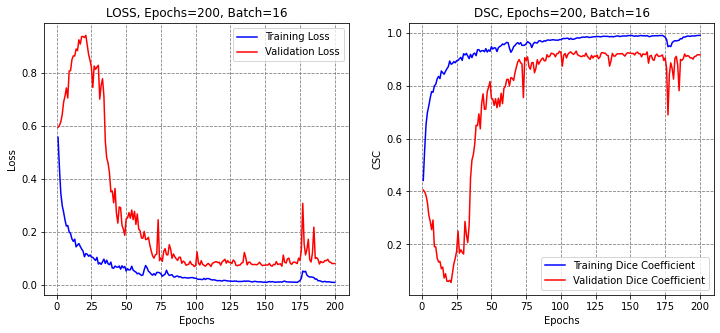

In [22]:
Representacion(history,epochnum,batchnum)

In [23]:
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()
# Evaluate model
num_test = len(X_test)
# Calculate performance metrics
dsc_sc = np.zeros((num_test,1))
iou_sc = np.zeros_like(dsc_sc)
rec_sc = np.zeros_like(dsc_sc)
tn_sc = np.zeros_like(dsc_sc)
prec_sc = np.zeros_like(dsc_sc)
thresh = 0.5
for i in range(num_test):
    dsc_sc[i], iou_sc[i], rec_sc[i], prec_sc[i] = auc(Y_test[i], preds_Dense[i] >thresh)
print('-'*30)
print('USING THRESHOLD', thresh)
print('\n DSC \t\t{0:^.3f} \n IOU \t\t{1:^.3f} \n Recall \t{2:^.3f} \n Precision\t{3:^.3f}'.format(
        np.sum(dsc_sc)/num_test,  
        np.sum(iou_sc)/num_test,  
        np.sum(rec_sc)/num_test,
        np.sum(prec_sc)/num_test))
    
# Confusion matrix
confusion = confusion_matrix(Y_test.ravel(),preds_Dense.ravel()>thresh)
accuracy = 0
if float(np.sum(confusion))!=0:
    accuracy = float(confusion[0,0]+confusion[1,1])/float(np.sum(confusion))
print(' Global Acc \t{0:^.3f}'.format(accuracy))
    
# Area under the ROC curve
AUC_ROC = roc_auc_score(preds_Dense.ravel()>thresh, Y_test.ravel())
print(' AUC ROC \t{0:^.3f}'.format(AUC_ROC))
print('\n')
print('*'*60)
    
# Save outputs 
numepochs = epochsn[-1]
dice_score = np.sum(dsc_sc)/num_test
iou_score = np.sum(iou_sc)/num_test
rec_score = np.sum(rec_sc)/num_test
prec_score = np.sum(prec_sc)/num_test
globacc_score = accuracy
auc_roc_score = AUC_ROC

------------------------------
USING THRESHOLD 0.5

 DSC 		0.405 
 IOU 		0.276 
 Recall 	0.390 
 Precision	0.453
 Global Acc 	0.935
 AUC ROC 	0.939


************************************************************


In [24]:
preds_Dense_val = model.predict(X_val)
# Evaluate model
num_val = len(X_val)
# Calculate performance metrics
dsc_sc = np.zeros((num_test,1))
iou_sc = np.zeros_like(dsc_sc)
rec_sc = np.zeros_like(dsc_sc)
tn_sc = np.zeros_like(dsc_sc)
prec_sc = np.zeros_like(dsc_sc)
thresh = 0.5
for i in range(num_val):
    dsc_sc[i], iou_sc[i], rec_sc[i], prec_sc[i] = auc(Y_val[i], preds_Dense_val[i] >thresh)
print('-'*30)
print('USING THRESHOLD', thresh)
print('\n DSC \t\t{0:^.3f} \n IOU \t\t{1:^.3f} \n Recall \t{2:^.3f} \n Precision\t{3:^.3f}'.format(
        np.sum(dsc_sc)/num_val,  
        np.sum(iou_sc)/num_val,  
        np.sum(rec_sc)/num_val,
        np.sum(prec_sc)/num_val))
    
# Confusion matrix
confusion = confusion_matrix(Y_val.ravel(),preds_Dense_val.ravel()>thresh)
accuracy = 0
if float(np.sum(confusion))!=0:
    accuracy = float(confusion[0,0]+confusion[1,1])/float(np.sum(confusion))
print(' Global Acc \t{0:^.3f}'.format(accuracy))
    
# Area under the ROC curve
AUC_ROC = roc_auc_score(preds_Dense_val.ravel()>thresh, Y_val.ravel())
print(' AUC ROC \t{0:^.3f}'.format(AUC_ROC))
print('\n')
print('*'*60)
    
# Save outputs 
numepochs = epochsn[-1]
dice_score = np.sum(dsc_sc)/num_val
iou_score = np.sum(iou_sc)/num_val
rec_score = np.sum(rec_sc)/num_val
prec_score = np.sum(prec_sc)/num_val
globacc_score = accuracy
auc_roc_score = AUC_ROC

1/1 [==============================] - 1s 955ms/step
------------------------------
USING THRESHOLD 0.5

 DSC 		0.442 
 IOU 		0.305 
 Recall 	0.432 
 Precision	0.460
 Global Acc 	0.946
 AUC ROC 	0.948


************************************************************


# Attention U-NET

In [25]:
from sklearn.model_selection import train_test_split
import tensorflow as tf

X_train, X_test, Y_train, Y_test = train_test_split(imgs, masks_, test_size=0.3, random_state = 0)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.2, random_state = 0)

X_train = tf.convert_to_tensor(X_train)
X_train = tf.reshape(X_train, [X_train.shape[0],X_train.shape[1],X_train.shape[2],1])

X_test = tf.convert_to_tensor(X_test)
X_test = tf.reshape(X_test, [X_test.shape[0],X_test.shape[1],X_test.shape[2],1])

Y_train = tf.convert_to_tensor(Y_train)
Y_train = tf.reshape(Y_train, [Y_train.shape[0],Y_train.shape[1],Y_train.shape[2],1])

Y_test = tf.convert_to_tensor(Y_test)
Y_test = tf.reshape(Y_test, [Y_test.shape[0],Y_test.shape[1],Y_test.shape[2],1])

X_val = tf.convert_to_tensor(X_val)
X_val = tf.reshape(X_val, [X_val.shape[0],X_val.shape[1],X_val.shape[2],1])

Y_val = tf.convert_to_tensor(Y_val)
Y_val = tf.reshape(Y_val, [Y_val.shape[0],Y_val.shape[1],Y_val.shape[2],1])

In [26]:
import keras_unet_collection
from keras_unet_collection._model_att_unet_2d import att_unet_2d

model = att_unet_2d(input_size, filter_num=[64, 128, 256, 512, 1024], n_labels=1, 
                           stack_num_down=2, stack_num_up=1, activation='ReLU', 
                           atten_activation='ReLU', attention='add', output_activation='Sigmoid', 
                           batch_norm=True, pool='max', unpool=False,  
                           name='attunet')

In [27]:
model.compile(loss=dice_loss,optimizer=keras.optimizers.Adam(learning_rate=1e-4), metrics=dsc)
import datetime
now = datetime.datetime.now
t = now()

history = model.fit(X_train, Y_train, validation_data = (X_val, Y_val), batch_size=batchnum, epochs=epochnum, verbose=1)

Epoch 1/200
7/7 [==============================] - 70s 9s/step - loss: 0.5029 - dsc: 0.4971 - val_loss: 0.5938 - val_dsc: 0.4076
Epoch 2/200
7/7 [==============================] - 61s 9s/step - loss: 0.3345 - dsc: 0.6655 - val_loss: 0.5962 - val_dsc: 0.4051
Epoch 3/200
7/7 [==============================] - 48s 7s/step - loss: 0.2597 - dsc: 0.7403 - val_loss: 0.6019 - val_dsc: 0.3995
Epoch 4/200
7/7 [==============================] - 52s 8s/step - loss: 0.2080 - dsc: 0.7920 - val_loss: 0.6112 - val_dsc: 0.3901
Epoch 5/200
7/7 [==============================] - 54s 8s/step - loss: 0.2007 - dsc: 0.7993 - val_loss: 0.6232 - val_dsc: 0.3780
Epoch 6/200
7/7 [==============================] - 52s 8s/step - loss: 0.1931 - dsc: 0.8069 - val_loss: 0.6382 - val_dsc: 0.3629
Epoch 7/200
7/7 [==============================] - 55s 8s/step - loss: 0.1658 - dsc: 0.8342 - val_loss: 0.6550 - val_dsc: 0.3460
Epoch 8/200
7/7 [==============================] - 55s 8s/step - loss: 0.1771 - dsc: 0.8229 - val

7/7 [==============================] - 64s 9s/step - loss: 0.0282 - dsc: 0.9718 - val_loss: 0.4790 - val_dsc: 0.5113
Epoch 65/200
7/7 [==============================] - 32s 5s/step - loss: 0.0276 - dsc: 0.9724 - val_loss: 0.4764 - val_dsc: 0.5144
Epoch 66/200
7/7 [==============================] - 33s 5s/step - loss: 0.0280 - dsc: 0.9720 - val_loss: 0.4357 - val_dsc: 0.5564
Epoch 67/200
7/7 [==============================] - 31s 4s/step - loss: 0.0263 - dsc: 0.9737 - val_loss: 0.3910 - val_dsc: 0.6022
Epoch 68/200
7/7 [==============================] - 30s 4s/step - loss: 0.0250 - dsc: 0.9750 - val_loss: 0.3711 - val_dsc: 0.6233
Epoch 69/200
7/7 [==============================] - 31s 4s/step - loss: 0.0259 - dsc: 0.9741 - val_loss: 0.3709 - val_dsc: 0.6235
Epoch 70/200
7/7 [==============================] - 31s 4s/step - loss: 0.0234 - dsc: 0.9766 - val_loss: 0.3371 - val_dsc: 0.6582
Epoch 71/200
7/7 [==============================] - 31s 4s/step - loss: 0.0206 - dsc: 0.9794 - val_loss

Epoch 127/200
7/7 [==============================] - 31s 4s/step - loss: 0.0097 - dsc: 0.9903 - val_loss: 0.0879 - val_dsc: 0.9103
Epoch 128/200
7/7 [==============================] - 31s 4s/step - loss: 0.0091 - dsc: 0.9909 - val_loss: 0.0891 - val_dsc: 0.9090
Epoch 129/200
7/7 [==============================] - 30s 4s/step - loss: 0.0100 - dsc: 0.9900 - val_loss: 0.0924 - val_dsc: 0.9057
Epoch 130/200
7/7 [==============================] - 31s 4s/step - loss: 0.0111 - dsc: 0.9889 - val_loss: 0.0923 - val_dsc: 0.9060
Epoch 131/200
7/7 [==============================] - 31s 4s/step - loss: 0.0095 - dsc: 0.9905 - val_loss: 0.0874 - val_dsc: 0.9111
Epoch 132/200
7/7 [==============================] - 31s 4s/step - loss: 0.0105 - dsc: 0.9895 - val_loss: 0.0896 - val_dsc: 0.9089
Epoch 133/200
7/7 [==============================] - 31s 4s/step - loss: 0.0086 - dsc: 0.9914 - val_loss: 0.0916 - val_dsc: 0.9066
Epoch 134/200
7/7 [==============================] - 30s 4s/step - loss: 0.0094 - d

7/7 [==============================] - 31s 4s/step - loss: 0.0047 - dsc: 0.9953 - val_loss: 0.0807 - val_dsc: 0.9177
Epoch 190/200
7/7 [==============================] - 31s 5s/step - loss: 0.0041 - dsc: 0.9959 - val_loss: 0.0829 - val_dsc: 0.9154
Epoch 191/200
7/7 [==============================] - 31s 4s/step - loss: 0.0050 - dsc: 0.9950 - val_loss: 0.0830 - val_dsc: 0.9154
Epoch 192/200
7/7 [==============================] - 31s 4s/step - loss: 0.0040 - dsc: 0.9960 - val_loss: 0.0812 - val_dsc: 0.9174
Epoch 193/200
7/7 [==============================] - 31s 4s/step - loss: 0.0049 - dsc: 0.9951 - val_loss: 0.0862 - val_dsc: 0.9128
Epoch 194/200
7/7 [==============================] - 31s 4s/step - loss: 0.0043 - dsc: 0.9957 - val_loss: 0.0823 - val_dsc: 0.9168
Epoch 195/200
7/7 [==============================] - 31s 4s/step - loss: 0.0040 - dsc: 0.9960 - val_loss: 0.0825 - val_dsc: 0.9164
Epoch 196/200
7/7 [==============================] - 31s 4s/step - loss: 0.0051 - dsc: 0.9949 - v

In [28]:
# Make predictions
t = now()
preds_Att = model.predict(X_test)
print('Testing time: %s' % (now() - t))

2/2 [==============================] - 4s 2s/step
Testing time: 0:00:03.863355


Training time: 0:00:03.866981


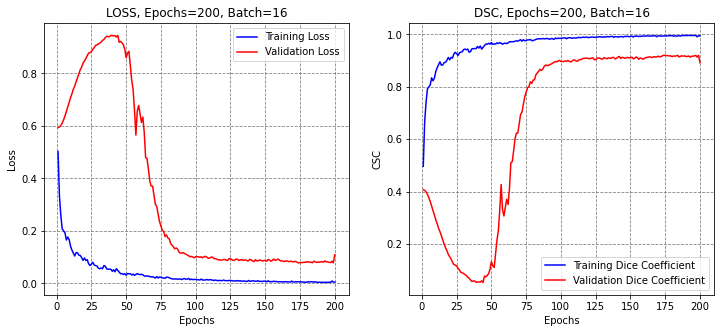

In [29]:
Representacion(history,epochnum,batchnum)

In [30]:
# Evaluate model
num_test = len(X_test)
# Calculate performance metrics
dsc_sc = np.zeros((num_test,1))
iou_sc = np.zeros_like(dsc_sc)
rec_sc = np.zeros_like(dsc_sc)
tn_sc = np.zeros_like(dsc_sc)
prec_sc = np.zeros_like(dsc_sc)
thresh = 0.5
for i in range(num_test):
    dsc_sc[i], iou_sc[i], rec_sc[i], prec_sc[i] = auc(Y_test[i], preds_Att[i] >thresh)
print('-'*30)
print('USING THRESHOLD', thresh)
print('\n DSC \t\t{0:^.3f} \n IOU \t\t{1:^.3f} \n Recall \t{2:^.3f} \n Precision\t{3:^.3f}'.format(
        np.sum(dsc_sc)/num_test,  
        np.sum(iou_sc)/num_test,  
        np.sum(rec_sc)/num_test,
        np.sum(prec_sc)/num_test))
    
# Confusion matrix
confusion = confusion_matrix(Y_test.ravel(),preds_Att.ravel()>thresh)
accuracy = 0
if float(np.sum(confusion))!=0:
    accuracy = float(confusion[0,0]+confusion[1,1])/float(np.sum(confusion))
print(' Global Acc \t{0:^.3f}'.format(accuracy))
    
# Area under the ROC curve
AUC_ROC = roc_auc_score(preds_Att.ravel()>thresh, Y_test.ravel())
print(' AUC ROC \t{0:^.3f}'.format(AUC_ROC))
print('\n')
print('*'*60)
    
# Save outputs 
numepochs = epochsn[-1]
dice_score = np.sum(dsc_sc)/num_test
iou_score = np.sum(iou_sc)/num_test
rec_score = np.sum(rec_sc)/num_test
prec_score = np.sum(prec_sc)/num_test
globacc_score = accuracy
auc_roc_score = AUC_ROC

------------------------------
USING THRESHOLD 0.5

 DSC 		0.851 
 IOU 		0.753 
 Recall 	0.934 
 Precision	0.806
 Global Acc 	0.917
 AUC ROC 	0.896


************************************************************


In [31]:
preds_Att_val = model.predict(X_val)
num_val = len(X_val)
# Calculate performance metrics
dsc_sc = np.zeros((num_val,1))
iou_sc = np.zeros_like(dsc_sc)
rec_sc = np.zeros_like(dsc_sc)
tn_sc = np.zeros_like(dsc_sc)
prec_sc = np.zeros_like(dsc_sc)
thresh = 0.5
for i in range(num_val):
    dsc_sc[i], iou_sc[i], rec_sc[i], prec_sc[i] = auc(Y_val[i], preds_Att_val[i] >thresh)
print('-'*30)
print('USING THRESHOLD', thresh)
print('\n DSC \t\t{0:^.3f} \n IOU \t\t{1:^.3f} \n Recall \t{2:^.3f} \n Precision\t{3:^.3f}'.format(
        np.sum(dsc_sc)/num_val,  
        np.sum(iou_sc)/num_val,  
        np.sum(rec_sc)/num_val,
        np.sum(prec_sc)/num_val))
    
# Confusion matrix
confusion = confusion_matrix(Y_val.ravel(),preds_Att_val.ravel()>thresh)
accuracy = 0
if float(np.sum(confusion))!=0:
    accuracy = float(confusion[0,0]+confusion[1,1])/float(np.sum(confusion))
print(' Global Acc \t{0:^.3f}'.format(accuracy))
    
# Area under the ROC curve
AUC_ROC = roc_auc_score(preds_Att_val.ravel()>thresh, Y_val.ravel())
print(' AUC ROC \t{0:^.3f}'.format(AUC_ROC))
print('\n')
print('*'*60)
    
# Save outputs 
numepochs = epochsn[-1]
dice_score = np.sum(dsc_sc)/num_val
iou_score = np.sum(iou_sc)/num_val
rec_score = np.sum(rec_sc)/num_val
prec_score = np.sum(prec_sc)/num_val
globacc_score = accuracy
auc_roc_score = AUC_ROC


1/1 [==============================] - 2s 2s/step
------------------------------
USING THRESHOLD 0.5

 DSC 		0.853 
 IOU 		0.767 
 Recall 	0.944 
 Precision	0.812
 Global Acc 	0.922
 AUC ROC 	0.908


************************************************************


# U-NET Dense + Attended

In [32]:
from keras.layers import *

def DenseBlock(channels,inputs):

    conv1_1 = Conv2D(channels, (1, 1),activation=None, padding='same')(inputs)
    conv1_1=BatchActivate(conv1_1)
    conv1_2 = Conv2D(channels//4, (3, 3), activation=None, padding='same')(conv1_1)
    conv1_2 = BatchActivate(conv1_2)

    conv2=concatenate([inputs,conv1_2])
    conv2_1 = Conv2D(channels, (1, 1), activation=None, padding='same')(conv2)
    conv2_1 = BatchActivate(conv2_1)
    conv2_2 = Conv2D(channels // 4, (3, 3), activation=None, padding='same')(conv2_1)
    conv2_2 = BatchActivate(conv2_2)

    conv3 = concatenate([inputs, conv1_2,conv2_2])
    conv3_1 = Conv2D(channels, (1, 1), activation=None, padding='same')(conv3)
    conv3_1 = BatchActivate(conv3_1)
    conv3_2 = Conv2D(channels // 4, (3, 3), activation=None, padding='same')(conv3_1)
    conv3_2 = BatchActivate(conv3_2)

    conv4 = concatenate([inputs, conv1_2, conv2_2,conv3_2])
    conv4_1 = Conv2D(channels, (1, 1), activation=None, padding='same')(conv4)
    conv4_1 = BatchActivate(conv4_1)
    conv4_2 = Conv2D(channels // 4, (3, 3), activation=None, padding='same')(conv4_1)
    conv4_2 = BatchActivate(conv4_2)
    result=concatenate([inputs,conv1_2, conv2_2,conv3_2,conv4_2])
    return result

def BatchActivate(x):
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x

def Attention_gate(g, s, num_filters):
    Wg = Conv2D(num_filters, 1, padding="same")(g)
    Wg = BatchNormalization()(Wg)
 
    Ws = Conv2D(num_filters, 1, padding="same")(s)
    Ws = BatchNormalization()(Ws)
    
    w = Add()([Wg,Ws])
 
    out = Activation("relu")(w)
    out = Conv2D(num_filters, 1, padding="same")(out)
    out = Activation("sigmoid")(out)
    return Multiply()([out,s])

In [33]:
from keras.optimizers import *
from keras.models import *

def DenseUNet_AttGate(start_neurons=16, keep_prob=0.9,block_size=7,lr=1e-3):

    inputs = Input(shape=input_size)
    conv1 = Conv2D(start_neurons * 1, (3, 3), activation=None, padding="same")(inputs)
    conv1 = BatchActivate(conv1)
    conv1 = DenseBlock(start_neurons * 1, conv1)
    pool1 = MaxPooling2D((2, 2))(conv1)

    conv2 = DenseBlock(start_neurons * 2, pool1)
    pool2 = MaxPooling2D((2, 2))(conv2)

    conv3 = DenseBlock(start_neurons * 4, pool2)
    pool3 = MaxPooling2D((2, 2))(conv3)


    convm = DenseBlock(start_neurons * 8, pool3)


    deconv3 = Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="same")(convm)
    Att3 = Attention_gate(conv3,deconv3,start_neurons * 4)  
    uconv3 = concatenate([deconv3, Att3])
    uconv3 = Conv2D(start_neurons * 4, (1, 1), activation=None, padding="same")(uconv3)
    uconv3 = BatchActivate(uconv3)
    uconv3 = DenseBlock(start_neurons * 4, uconv3)


    deconv2 = Conv2DTranspose(start_neurons * 2, (3, 3), strides=(2, 2), padding="same")(uconv3)
    Att2 = Attention_gate(conv2,deconv2,start_neurons * 2)  
    uconv2 = concatenate([deconv2, Att2])
    uconv2 = Conv2D(start_neurons * 2, (1, 1), activation=None, padding="same")(uconv2)
    uconv2 = BatchActivate(uconv2)
    uconv2 = DenseBlock(start_neurons * 2, uconv2)

    deconv1 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="same")(uconv2)
    Att1 = Attention_gate(conv1,deconv1,start_neurons * 1)  
    uconv1 = concatenate([deconv1, Att1])
    uconv1 = Conv2D(start_neurons * 1, (1, 1), activation=None, padding="same")(uconv1)
    uconv1 = BatchActivate(uconv1)
    uconv1 = DenseBlock(start_neurons * 1, uconv1)

    output_layer_noActi = Conv2D(1, (1, 1), padding="same", activation=None)(uconv1)
    output_layer = Activation('sigmoid')(output_layer_noActi)
    
    model = Model(inputs=inputs, outputs=output_layer)
    model.compile(optimizer=Adam(lr=1e-3), loss=dice_loss, metrics=[dsc])

    return model

In [34]:
from sklearn.model_selection import train_test_split
keras.backend.clear_session()
X_train, X_test, Y_train, Y_test = train_test_split(imgs, masks_, test_size=0.3, random_state = 0)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.2, random_state = 0)
model2 = DenseUNet_AttGate()

In [35]:
t = now()

history = model2.fit(X_train, Y_train, validation_data = (X_val, Y_val), batch_size=batchnum, epochs=epochnum, verbose=1)

Epoch 1/200
7/7 [==============================] - 27s 2s/step - loss: 0.4739 - dsc: 0.5261 - val_loss: 0.5928 - val_dsc: 0.4086
Epoch 2/200
7/7 [==============================] - 12s 2s/step - loss: 0.3594 - dsc: 0.6406 - val_loss: 0.6007 - val_dsc: 0.4006
Epoch 3/200
7/7 [==============================] - 12s 2s/step - loss: 0.3141 - dsc: 0.6859 - val_loss: 0.6191 - val_dsc: 0.3820
Epoch 4/200
7/7 [==============================] - 12s 2s/step - loss: 0.2872 - dsc: 0.7128 - val_loss: 0.6363 - val_dsc: 0.3648
Epoch 5/200
7/7 [==============================] - 12s 2s/step - loss: 0.2651 - dsc: 0.7349 - val_loss: 0.6570 - val_dsc: 0.3440
Epoch 6/200
7/7 [==============================] - 12s 2s/step - loss: 0.2529 - dsc: 0.7471 - val_loss: 0.6775 - val_dsc: 0.3233
Epoch 7/200
7/7 [==============================] - 12s 2s/step - loss: 0.2495 - dsc: 0.7505 - val_loss: 0.6997 - val_dsc: 0.3010
Epoch 8/200
7/7 [==============================] - 12s 2s/step - loss: 0.2412 - dsc: 0.7588 - val

7/7 [==============================] - 12s 2s/step - loss: 0.0682 - dsc: 0.9318 - val_loss: 0.1411 - val_dsc: 0.8602
Epoch 65/200
7/7 [==============================] - 12s 2s/step - loss: 0.0602 - dsc: 0.9398 - val_loss: 0.1325 - val_dsc: 0.8694
Epoch 66/200
7/7 [==============================] - 12s 2s/step - loss: 0.0732 - dsc: 0.9268 - val_loss: 0.1255 - val_dsc: 0.8743
Epoch 67/200
7/7 [==============================] - 12s 2s/step - loss: 0.0634 - dsc: 0.9366 - val_loss: 0.1101 - val_dsc: 0.8885
Epoch 68/200
7/7 [==============================] - 12s 2s/step - loss: 0.0679 - dsc: 0.9321 - val_loss: 0.1325 - val_dsc: 0.8662
Epoch 69/200
7/7 [==============================] - 12s 2s/step - loss: 0.0566 - dsc: 0.9434 - val_loss: 0.1696 - val_dsc: 0.8280
Epoch 70/200
7/7 [==============================] - 12s 2s/step - loss: 0.0443 - dsc: 0.9557 - val_loss: 0.1181 - val_dsc: 0.8789
Epoch 71/200
7/7 [==============================] - 12s 2s/step - loss: 0.0471 - dsc: 0.9529 - val_loss

Epoch 127/200
7/7 [==============================] - 12s 2s/step - loss: 0.0170 - dsc: 0.9830 - val_loss: 0.0881 - val_dsc: 0.9105
Epoch 128/200
7/7 [==============================] - 12s 2s/step - loss: 0.0177 - dsc: 0.9823 - val_loss: 0.0876 - val_dsc: 0.9104
Epoch 129/200
7/7 [==============================] - 12s 2s/step - loss: 0.0164 - dsc: 0.9836 - val_loss: 0.0839 - val_dsc: 0.9144
Epoch 130/200
7/7 [==============================] - 12s 2s/step - loss: 0.0181 - dsc: 0.9819 - val_loss: 0.0847 - val_dsc: 0.9140
Epoch 131/200
7/7 [==============================] - 12s 2s/step - loss: 0.0162 - dsc: 0.9838 - val_loss: 0.0789 - val_dsc: 0.9203
Epoch 132/200
7/7 [==============================] - 12s 2s/step - loss: 0.0159 - dsc: 0.9841 - val_loss: 0.0773 - val_dsc: 0.9210
Epoch 133/200
7/7 [==============================] - 12s 2s/step - loss: 0.0161 - dsc: 0.9839 - val_loss: 0.0828 - val_dsc: 0.9152
Epoch 134/200
7/7 [==============================] - 12s 2s/step - loss: 0.0167 - d

7/7 [==============================] - 12s 2s/step - loss: 0.0138 - dsc: 0.9862 - val_loss: 0.0992 - val_dsc: 0.8990
Epoch 190/200
7/7 [==============================] - 12s 2s/step - loss: 0.0168 - dsc: 0.9832 - val_loss: 0.1028 - val_dsc: 0.8955
Epoch 191/200
7/7 [==============================] - 12s 2s/step - loss: 0.0134 - dsc: 0.9866 - val_loss: 0.0919 - val_dsc: 0.9057
Epoch 192/200
7/7 [==============================] - 12s 2s/step - loss: 0.0163 - dsc: 0.9837 - val_loss: 0.1591 - val_dsc: 0.8418
Epoch 193/200
7/7 [==============================] - 12s 2s/step - loss: 0.0132 - dsc: 0.9868 - val_loss: 0.0845 - val_dsc: 0.9153
Epoch 194/200
7/7 [==============================] - 12s 2s/step - loss: 0.0133 - dsc: 0.9867 - val_loss: 0.0815 - val_dsc: 0.9175
Epoch 195/200
7/7 [==============================] - 12s 2s/step - loss: 0.0154 - dsc: 0.9846 - val_loss: 0.0918 - val_dsc: 0.9067
Epoch 196/200
7/7 [==============================] - 12s 2s/step - loss: 0.0169 - dsc: 0.9831 - v

In [36]:
# Make predictions
t = now()
preds_DA = model2.predict(X_test)
print('Testing time: %s' % (now() - t))

2/2 [==============================] - 2s 427ms/step
Testing time: 0:00:01.829036


Training time: 0:00:01.831984


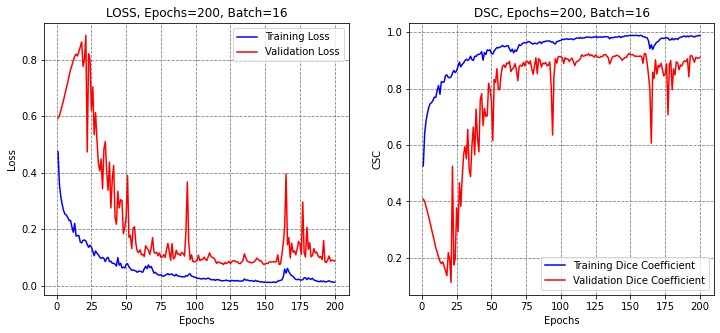

In [37]:
Representacion(history,epochnum,batchnum)

In [38]:
# Evaluate model
num_test = len(X_test)
# Calculate performance metrics
dsc_sc = np.zeros((num_test,1))
iou_sc = np.zeros_like(dsc_sc)
rec_sc = np.zeros_like(dsc_sc)
tn_sc = np.zeros_like(dsc_sc)
prec_sc = np.zeros_like(dsc_sc)
thresh = 0.5
for i in range(num_test):
    dsc_sc[i], iou_sc[i], rec_sc[i], prec_sc[i] = auc(Y_test[i], preds_DA[i,:,:,0] >thresh)
print('-'*30)
print('USING THRESHOLD', thresh)
print('\n DSC \t\t{0:^.3f} \n IOU \t\t{1:^.3f} \n Recall \t{2:^.3f} \n Precision\t{3:^.3f}'.format(
        np.sum(dsc_sc)/num_test,  
        np.sum(iou_sc)/num_test,  
        np.sum(rec_sc)/num_test,
        np.sum(prec_sc)/num_test))
    
# Confusion matrix
confusion = confusion_matrix(Y_test.ravel(),preds_DA.ravel()>thresh)
accuracy = 0
if float(np.sum(confusion))!=0:
    accuracy = float(confusion[0,0]+confusion[1,1])/float(np.sum(confusion))
print(' Global Acc \t{0:^.3f}'.format(accuracy))
    
# Area under the ROC curve
AUC_ROC = roc_auc_score(preds_DA.ravel()>thresh, Y_test.ravel())
print(' AUC ROC \t{0:^.3f}'.format(AUC_ROC))
print('\n')
print('*'*60)
    
# Save outputs 
numepochs = epochsn[-1]
dice_score = np.sum(dsc_sc)/num_test
iou_score = np.sum(iou_sc)/num_test
rec_score = np.sum(rec_sc)/num_test
prec_score = np.sum(prec_sc)/num_test
globacc_score = accuracy
auc_roc_score = AUC_ROC

------------------------------
USING THRESHOLD 0.5

 DSC 		0.884 
 IOU 		0.810 
 Recall 	0.864 
 Precision	0.938
 Global Acc 	0.941
 AUC ROC 	0.941


************************************************************


In [39]:
preds_DA_val = model2.predict(X_val)
num_val = len(X_val)
# Calculate performance metrics
dsc_sc = np.zeros((num_val,1))
iou_sc = np.zeros_like(dsc_sc)
rec_sc = np.zeros_like(dsc_sc)
tn_sc = np.zeros_like(dsc_sc)
prec_sc = np.zeros_like(dsc_sc)
thresh = 0.5
for i in range(num_val):
    dsc_sc[i], iou_sc[i], rec_sc[i], prec_sc[i] = auc(Y_val[i], preds_DA_val[i,:,:,0] >thresh)
print('-'*30)
print('USING THRESHOLD', thresh)
print('\n DSC \t\t{0:^.3f} \n IOU \t\t{1:^.3f} \n Recall \t{2:^.3f} \n Precision\t{3:^.3f}'.format(
        np.sum(dsc_sc)/num_val,  
        np.sum(iou_sc)/num_val,  
        np.sum(rec_sc)/num_val,
        np.sum(prec_sc)/num_val))
    
# Confusion matrix
confusion = confusion_matrix(Y_val.ravel(),preds_DA_val.ravel()>thresh)
accuracy = 0
if float(np.sum(confusion))!=0:
    accuracy = float(confusion[0,0]+confusion[1,1])/float(np.sum(confusion))
print(' Global Acc \t{0:^.3f}'.format(accuracy))
    
# Area under the ROC curve
AUC_ROC = roc_auc_score(preds_DA_val.ravel()>thresh, Y_val.ravel())
print(' AUC ROC \t{0:^.3f}'.format(AUC_ROC))
print('\n')
print('*'*60)
    
# Save outputs 
numepochs = epochsn[-1]
dice_score = np.sum(dsc_sc)/num_val
iou_score = np.sum(iou_sc)/num_val
rec_score = np.sum(rec_sc)/num_val
prec_score = np.sum(prec_sc)/num_val
globacc_score = accuracy
auc_roc_score = AUC_ROC

1/1 [==============================] - 0s 473ms/step
------------------------------
USING THRESHOLD 0.5

 DSC 		0.902 
 IOU 		0.828 
 Recall 	0.871 
 Precision	0.948
 Global Acc 	0.943
 AUC ROC 	0.947


************************************************************


# U-NET 3+

In [40]:
from keras_unet_collection import models, base, utils
model = models.unet_3plus_2d(input_size, n_labels=1, filter_num_down=[64, 128, 256, 512], 
                             filter_num_skip='auto', filter_num_aggregate='auto', 
                             stack_num_down=2, stack_num_up=1, activation='ReLU', output_activation='Sigmoid',
                             batch_norm=True, pool='max', unpool=False, deep_supervision=False, name='unet3plus')

Automated hyper-parameter determination is applied with the following details:
----------
	Number of convolution filters after each full-scale skip connection: filter_num_skip = [64, 64, 64]
	Number of channels of full-scale aggregated feature maps: filter_num_aggregate = 256


In [41]:
model.compile(loss=dice_loss,optimizer=keras.optimizers.Adam(learning_rate=1e-4), metrics=[dsc]) # lr adaptativo

import datetime
now = datetime.datetime.now
t = now()

history = model.fit(X_train, Y_train, validation_data = (X_val, Y_val), batch_size=batchnum, epochs=epochnum, verbose=1)

Epoch 1/200
7/7 [==============================] - 53s 7s/step - loss: 0.4828 - dsc: 0.5172 - val_loss: 0.5944 - val_dsc: 0.4069
Epoch 2/200
7/7 [==============================] - 48s 7s/step - loss: 0.2931 - dsc: 0.7069 - val_loss: 0.6076 - val_dsc: 0.3937
Epoch 3/200
7/7 [==============================] - 49s 7s/step - loss: 0.2016 - dsc: 0.7984 - val_loss: 0.6331 - val_dsc: 0.3680
Epoch 4/200
7/7 [==============================] - 48s 7s/step - loss: 0.1864 - dsc: 0.8136 - val_loss: 0.6726 - val_dsc: 0.3284
Epoch 5/200
7/7 [==============================] - 48s 7s/step - loss: 0.1567 - dsc: 0.8433 - val_loss: 0.7246 - val_dsc: 0.2761
Epoch 6/200
7/7 [==============================] - 48s 7s/step - loss: 0.1565 - dsc: 0.8435 - val_loss: 0.7757 - val_dsc: 0.2248
Epoch 7/200
7/7 [==============================] - 48s 7s/step - loss: 0.1523 - dsc: 0.8477 - val_loss: 0.8233 - val_dsc: 0.1770
Epoch 8/200
7/7 [==============================] - 48s 7s/step - loss: 0.1482 - dsc: 0.8518 - val

Epoch 64/200
7/7 [==============================] - 49s 7s/step - loss: 0.0219 - dsc: 0.9781 - val_loss: 0.6673 - val_dsc: 0.3219
Epoch 65/200
7/7 [==============================] - 48s 7s/step - loss: 0.0200 - dsc: 0.9800 - val_loss: 0.6408 - val_dsc: 0.3497
Epoch 66/200
7/7 [==============================] - 48s 7s/step - loss: 0.0248 - dsc: 0.9752 - val_loss: 0.5329 - val_dsc: 0.4570
Epoch 67/200
7/7 [==============================] - 49s 7s/step - loss: 0.0241 - dsc: 0.9759 - val_loss: 0.5649 - val_dsc: 0.4259
Epoch 68/200
7/7 [==============================] - 48s 7s/step - loss: 0.0213 - dsc: 0.9787 - val_loss: 0.5518 - val_dsc: 0.4368
Epoch 69/200
7/7 [==============================] - 49s 7s/step - loss: 0.0191 - dsc: 0.9809 - val_loss: 0.4572 - val_dsc: 0.5355
Epoch 70/200
7/7 [==============================] - 49s 7s/step - loss: 0.0171 - dsc: 0.9829 - val_loss: 0.3798 - val_dsc: 0.6147
Epoch 71/200
7/7 [==============================] - 48s 7s/step - loss: 0.0186 - dsc: 0.98

Epoch 127/200
7/7 [==============================] - 50s 7s/step - loss: 0.0075 - dsc: 0.9925 - val_loss: 0.0942 - val_dsc: 0.9024
Epoch 128/200
7/7 [==============================] - 52s 8s/step - loss: 0.0109 - dsc: 0.9891 - val_loss: 0.0960 - val_dsc: 0.9017
Epoch 129/200
7/7 [==============================] - 48s 7s/step - loss: 0.0082 - dsc: 0.9918 - val_loss: 0.0905 - val_dsc: 0.9075
Epoch 130/200
7/7 [==============================] - 48s 7s/step - loss: 0.0068 - dsc: 0.9932 - val_loss: 0.0950 - val_dsc: 0.9023
Epoch 131/200
7/7 [==============================] - 48s 7s/step - loss: 0.0057 - dsc: 0.9943 - val_loss: 0.0963 - val_dsc: 0.9011
Epoch 132/200
7/7 [==============================] - 49s 7s/step - loss: 0.0051 - dsc: 0.9949 - val_loss: 0.0864 - val_dsc: 0.9111
Epoch 133/200
7/7 [==============================] - 48s 7s/step - loss: 0.0060 - dsc: 0.9940 - val_loss: 0.0904 - val_dsc: 0.9071
Epoch 134/200
7/7 [==============================] - 48s 7s/step - loss: 0.0069 - d

7/7 [==============================] - 48s 7s/step - loss: 0.0022 - dsc: 0.9978 - val_loss: 0.0880 - val_dsc: 0.9092
Epoch 190/200
7/7 [==============================] - 48s 7s/step - loss: 0.0019 - dsc: 0.9981 - val_loss: 0.0881 - val_dsc: 0.9089
Epoch 191/200
7/7 [==============================] - 48s 7s/step - loss: 0.0018 - dsc: 0.9982 - val_loss: 0.0916 - val_dsc: 0.9055
Epoch 192/200
7/7 [==============================] - 49s 7s/step - loss: 0.0016 - dsc: 0.9984 - val_loss: 0.0862 - val_dsc: 0.9116
Epoch 193/200
7/7 [==============================] - 49s 7s/step - loss: 0.0023 - dsc: 0.9977 - val_loss: 0.0841 - val_dsc: 0.9136
Epoch 194/200
7/7 [==============================] - 48s 7s/step - loss: 0.0021 - dsc: 0.9979 - val_loss: 0.0865 - val_dsc: 0.9111
Epoch 195/200
7/7 [==============================] - 48s 7s/step - loss: 0.0017 - dsc: 0.9983 - val_loss: 0.0856 - val_dsc: 0.9118
Epoch 196/200
7/7 [==============================] - 48s 7s/step - loss: 0.0020 - dsc: 0.9980 - v

In [42]:
# Make predictions
t = now()
preds_3p = model.predict(X_test)
print('Testing time: %s' % (now() - t))

2/2 [==============================] - 6s 3s/step
Testing time: 0:00:06.426054


Training time: 0:00:06.432382


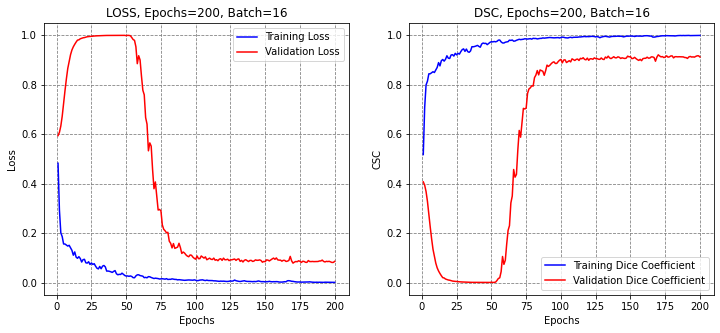

In [43]:
Representacion(history,epochnum,batchnum)

In [44]:
# Evaluate model
num_test = len(X_test)
# Calculate performance metrics
dsc_sc = np.zeros((num_test,1))
iou_sc = np.zeros_like(dsc_sc)
rec_sc = np.zeros_like(dsc_sc)
tn_sc = np.zeros_like(dsc_sc)
prec_sc = np.zeros_like(dsc_sc)
thresh = 0.5
for i in range(num_test):
    dsc_sc[i], iou_sc[i], rec_sc[i], prec_sc[i] = auc(Y_test[i], preds_3p[i] >thresh)
print('-'*30)
print('USING THRESHOLD', thresh)
print('\n DSC \t\t{0:^.3f} \n IOU \t\t{1:^.3f} \n Recall \t{2:^.3f} \n Precision\t{3:^.3f}'.format(
        np.sum(dsc_sc)/num_test,  
        np.sum(iou_sc)/num_test,  
        np.sum(rec_sc)/num_test,
        np.sum(prec_sc)/num_test))
    
# Confusion matrix
confusion = confusion_matrix(Y_test.ravel(),preds_3p.ravel()>thresh)
accuracy = 0
if float(np.sum(confusion))!=0:
    accuracy = float(confusion[0,0]+confusion[1,1])/float(np.sum(confusion))
print(' Global Acc \t{0:^.3f}'.format(accuracy))
    
# Area under the ROC curve
AUC_ROC = roc_auc_score(preds_3p.ravel()>thresh, Y_test.ravel())
print(' AUC ROC \t{0:^.3f}'.format(AUC_ROC))
print('\n')
print('*'*60)
    
# Save outputs 
numepochs = epochsn[-1]
dice_score = np.sum(dsc_sc)/num_test
iou_score = np.sum(iou_sc)/num_test
rec_score = np.sum(rec_sc)/num_test
prec_score = np.sum(prec_sc)/num_test
globacc_score = accuracy
auc_roc_score = AUC_ROC

------------------------------
USING THRESHOLD 0.5

 DSC 		0.417 
 IOU 		0.284 
 Recall 	0.405 
 Precision	0.440
 Global Acc 	0.938
 AUC ROC 	0.939


************************************************************


In [45]:
preds_3p_val = model.predict(X_val)
# Evaluate model
num_val = len(X_val)
# Calculate performance metrics
dsc_sc = np.zeros((num_val,1))
iou_sc = np.zeros_like(dsc_sc)
rec_sc = np.zeros_like(dsc_sc)
tn_sc = np.zeros_like(dsc_sc)
prec_sc = np.zeros_like(dsc_sc)
thresh = 0.5
for i in range(num_val):
    dsc_sc[i], iou_sc[i], rec_sc[i], prec_sc[i] = auc(Y_val[i], preds_3p_val[i] >thresh)
print('-'*30)
print('USING THRESHOLD', thresh)
print('\n DSC \t\t{0:^.3f} \n IOU \t\t{1:^.3f} \n Recall \t{2:^.3f} \n Precision\t{3:^.3f}'.format(
        np.sum(dsc_sc)/num_val,  
        np.sum(iou_sc)/num_val,  
        np.sum(rec_sc)/num_val,
        np.sum(prec_sc)/num_val))
    
# Confusion matrix
confusion = confusion_matrix(Y_val.ravel(),preds_3p_val.ravel()>thresh)
accuracy = 0
if float(np.sum(confusion))!=0:
    accuracy = float(confusion[0,0]+confusion[1,1])/float(np.sum(confusion))
print(' Global Acc \t{0:^.3f}'.format(accuracy))
    
# Area under the ROC curve
AUC_ROC = roc_auc_score(preds_3p_val.ravel()>thresh, Y_val.ravel())
print(' AUC ROC \t{0:^.3f}'.format(AUC_ROC))
print('\n')
print('*'*60)
    
# Save outputs 
numepochs = epochsn[-1]
dice_score = np.sum(dsc_sc)/num_val
iou_score = np.sum(iou_sc)/num_val
rec_score = np.sum(rec_sc)/num_val
prec_score = np.sum(prec_sc)/num_val
globacc_score = accuracy
auc_roc_score = AUC_ROC

1/1 [==============================] - 3s 3s/step
------------------------------
USING THRESHOLD 0.5

 DSC 		0.443 
 IOU 		0.305 
 Recall 	0.433 
 Precision	0.459
 Global Acc 	0.942
 AUC ROC 	0.944


************************************************************


# Representación de las mascaras 

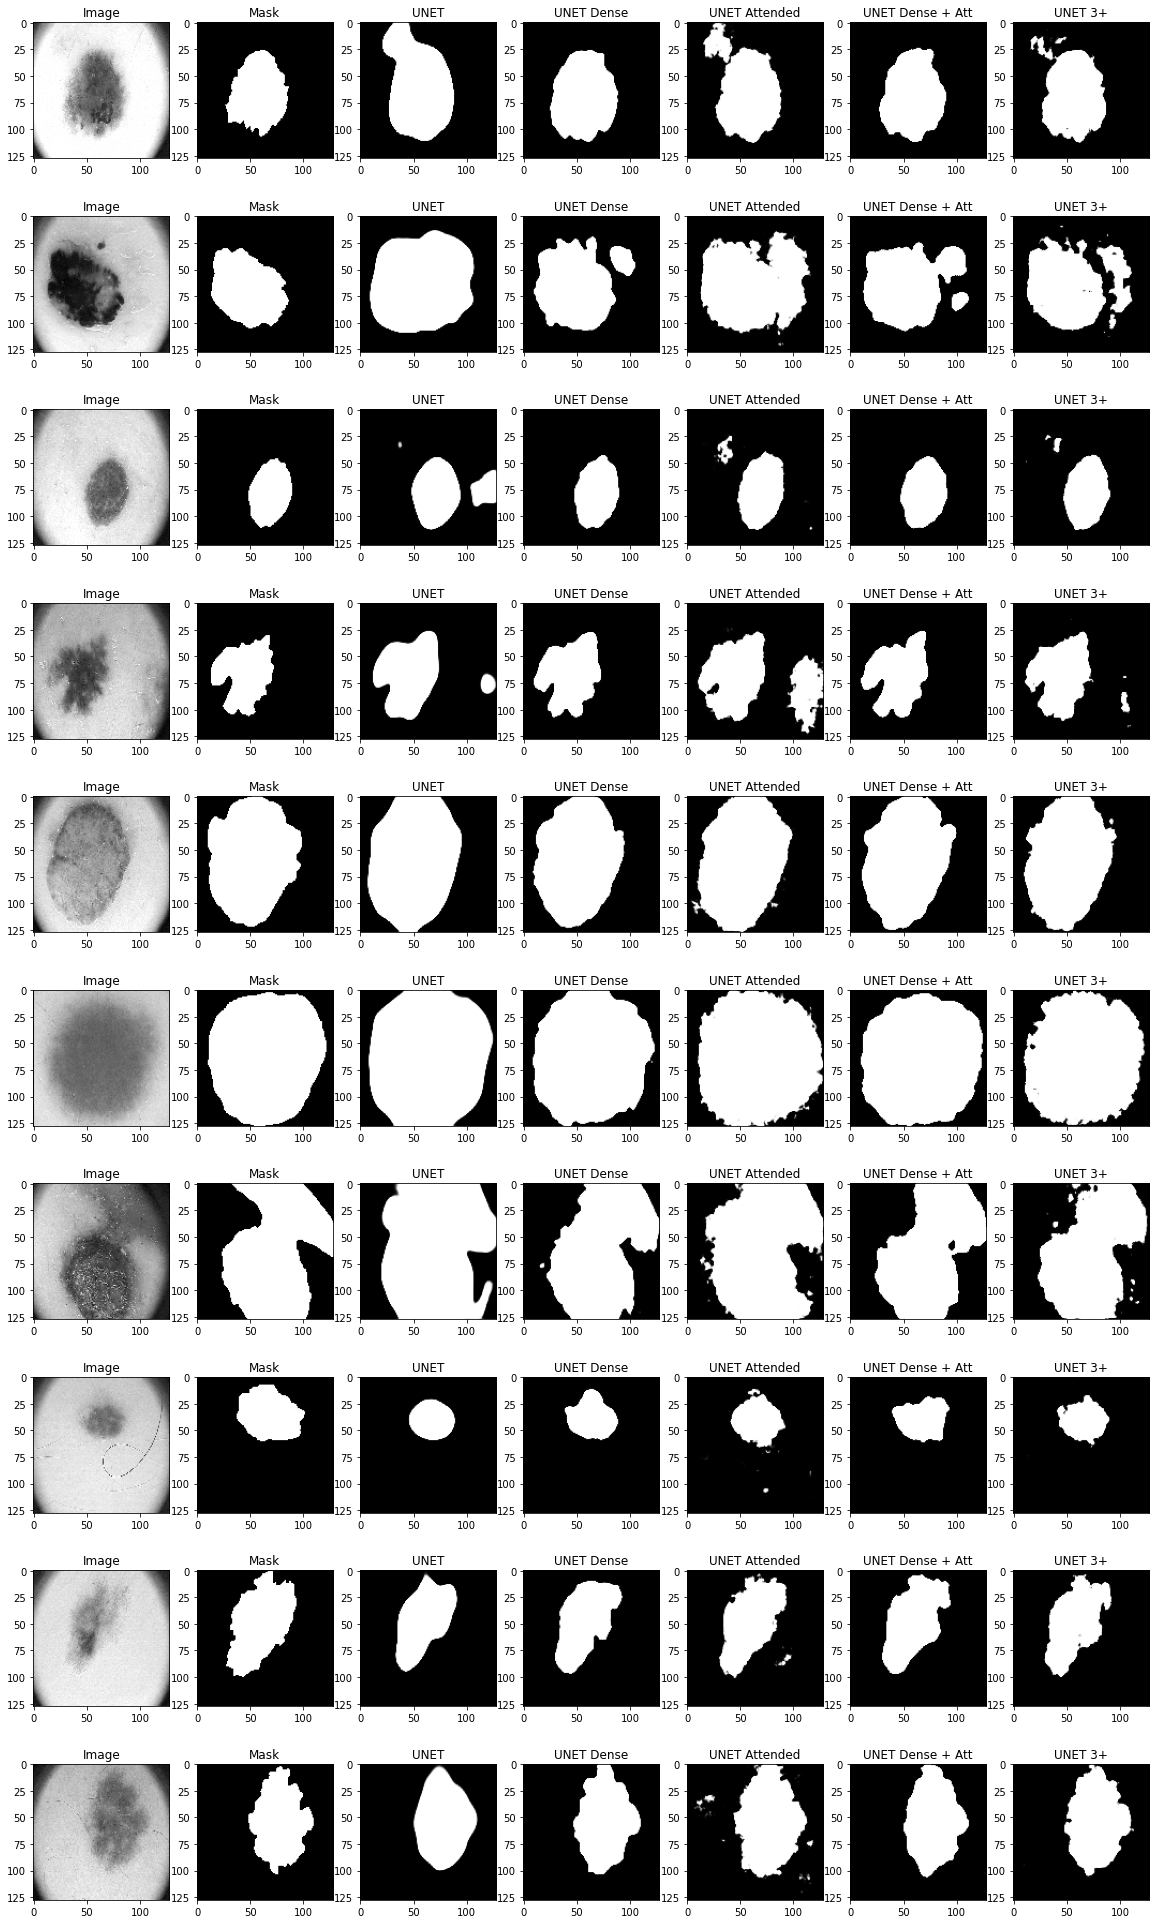

In [46]:
# To plot a set of images with predicted masks uncomment these lines
j = 0
import random
n1 = random.randint(0,len(X_test)-1)
n2 = random.randint(0,len(X_test)-1)
n3 = random.randint(0,len(X_test)-1)
n4 = random.randint(0,len(X_test)-1)
n5 = random.randint(0,len(X_test)-1)
n6 = random.randint(0,len(X_test)-1)
n7 = random.randint(0,len(X_test)-1)
n8 = random.randint(0,len(X_test)-1)
n9 = random.randint(0,len(X_test)-1)
n10 = random.randint(0,len(X_test)-1)

num_disp = [n1,n2,n3,n4,n5,n6,n7,n8,n9,n10]
j=1
plt.figure(figsize = (20,35))
for i in num_disp:
    plt.subplot(10,7,j)
    plt.imshow(np.squeeze(X_test[i]), cmap='gray')
    plt.title('Image')
    j +=1
    plt.subplot(10,7,j)
    plt.imshow(np.squeeze(Y_test[i]),cmap='gray')
    plt.title('Mask')
    j +=1
    plt.subplot(10,7,j)
    plt.imshow(np.squeeze(preds_UNET[i]),cmap='gray')
    plt.title('UNET')
    j +=1
    plt.subplot(10,7,j)
    plt.imshow(np.squeeze(preds_Dense[i]),cmap='gray')
    plt.title('UNET Dense')
    j +=1
    plt.subplot(10,7,j)
    plt.imshow(np.squeeze(preds_Att[i]),cmap='gray')
    plt.title('UNET Attended')
    j +=1
    plt.subplot(10,7,j)
    plt.imshow(np.squeeze(preds_DA[i]),cmap='gray')
    plt.title('UNET Dense + Att')
    j +=1
    plt.subplot(10,7,j)
    plt.imshow(np.squeeze(preds_3p[i]),cmap='gray')
    plt.title('UNET 3+')
    j +=1
    

plt.savefig('Masks.png')
plt.show()